# ML in Cybersecurity: Task I

## Team
  * **Team name**:  *SaS*
  * **Members**:  * Shantanu Kumar Rahut(shra00001@stud.uni-saarland.de), Aleeza Suhel Inamdar (alin00002@stud.uni-saarland.de), Shashank Priyadarshi (shpr00001@stud.uni-saarland.de) *


## Logistics
  * **Due date**: 12th December 2023, 23:59:59 (email the completed notebook including outputs to raouf.kerkouche@cispa.de)
  * Please include your team name and the task number in the file name and the email subject
  * Complete this in **teams of 3** (if possible).
  * Feel free to use the forum or the mailing list to find group members.
  
## Timeline
  * 29-Nov-2023: Task 1 hand-out
  * **12-Dec-2023** (23:59:59)
  * 13-Dec-2023: Task 1 discussion and summary
  
  
## About this task
In this task, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at the [second](https://dl.cispa.de/s/xjScpfKwJP2RTzo) lecture. Within this framework, the following blocks of this task are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*


## A Note on Grading
The grading for this task will depend on:
 1. Functional digit classifier
   * Following a well-defined ML pipeline
   * Developing 3 classification models (keep them diverse and ideally of increasing complexity)
   * Obtaining reasonable accuracies (>80%) on a held-out test set
 1. Analysis
   * Which methods work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
    * Anything else you find interesting (this part is open-ended)
  
 A note on (1.):
  * Choose your models that aids good insights. We require at least one non-Neural Network (e.g., SVM, KNN) and one Neural Network model (e.g., MLP, CNN).
  * We definitely don't expect all three models to achieve >99% test accuracies!


## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it).

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your task report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.


 ## Versions
  * v2.0: Added pytorch
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import json
import time
import pickle
import sys
import csv
import os
import os.path as osp
import shutil

import pandas as pd

from IPython.display import display, HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)

# for non neural network models
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# for neural network models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# set random seed. Change the random seed to get different result for the same training and testing split
# use the variable 'random_seed' in your code for random seed

random_seed = 42 # DO NOT CHANGE THIS VALUE

# Jupyter notebook sometimes don't follow the random seed value in every cell, so it's better to set the random seed in every cell
np.random.seed(random_seed) # Copy this line to every cell where you use random seed
torch.manual_seed(random_seed) # Copy this line to every cell where you use random seed
 


Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
def identity_func(foo):
    return foo


#
#
# ------- Your Code -------
#
#

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.uint8)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()

# 1. Loading and Visualizing data

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint train, val, and test splits!

In [4]:
# THIS IS OUT CODE: START

# Jupyter notebook sometimes don't follow the random seed value in every cell, so it's better to set the random seed in every cell
np.random.seed(random_seed) # Copy this line to every cell where you use random seed
torch.manual_seed(random_seed) # Copy this line to every cell where you use random seed

# Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# ------------------ For PyTorch ------------------
# Defining the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the data from torchvision.datasets.MNIST
mnist_dataset_trainval = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_dataset_test = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)

# This is for visualization purpose only
x_trainval, y_trainval = mnist_dataset_trainval.data, mnist_dataset_trainval.targets
x_test, y_test = mnist_dataset_test.data, mnist_dataset_test.targets

# Split the training data into train and validation sets
train_size = int(0.8 * len(mnist_dataset_trainval))
val_size = len(mnist_dataset_trainval) - train_size
train_dataset, val_dataset = random_split(mnist_dataset_trainval, [train_size, val_size])

# Create data loaders
batch_size = 64 # 64 is the default batch size in PyTorch, Change it if you need to

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False)

# Display dataset shapes
print("\n\nFor using PyTorch based models:")
print(f'Train dataset size: {len(train_loader.dataset)}')
print(f'Validation dataset size: {len(val_loader.dataset)}')
print(f'Test dataset size: {len(test_loader.dataset)}')


# ------------------ For sklearn ------------------

# convert the data to numpy arrays for sklearn
x_trainval_sklearn = mnist_dataset_trainval.data.numpy()
y_trainval_sklearn  = mnist_dataset_trainval.targets.numpy()

x_test_sklearn  = mnist_dataset_test.data.numpy()
y_test_sklearn  = mnist_dataset_test.targets.numpy()

# flatten the input images
x_trainval_sklearn  = flatten_input_pixels(x_trainval_sklearn )
x_test_sklearn  = flatten_input_pixels(x_test_sklearn)

# Display dataset shapes
print("\n\nFor using sklearn based models:")
print(f'Train-val dataset size: {x_trainval_sklearn.shape}')
print(f'Test dataset size: {x_test_sklearn.shape}')



# THIS IS OUT CODE: END




############ Things that we don't need from the original file are down here. Use them if needed later ############

# print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
# print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
# DEBUG_FRAC = 0.05
# x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
# y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]

cuda:0


For using PyTorch based models:
Train dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000


For using sklearn based models:
Train-val dataset size: (60000, 784)
Test dataset size: (10000, 784)


#### 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 5, [Lecture 2](https://dl.cispa.de/s/xjScpfKwJP2RTzo)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

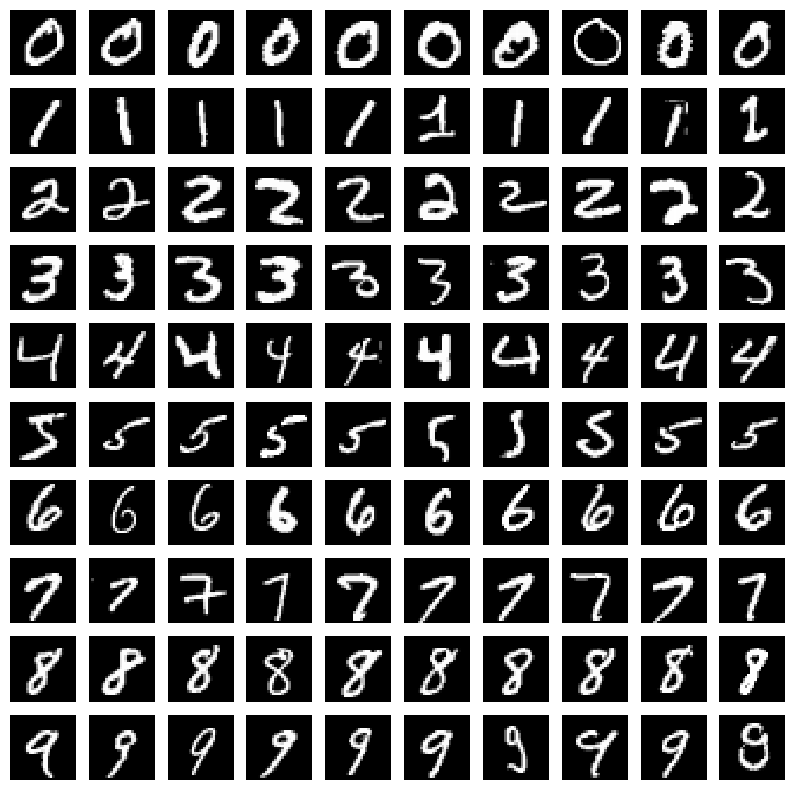

In [5]:
# Visualize 10 examples from each of the 10 classes
rows, cols = 10, 10
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))

# Dictionary to store indices of each class
class_indices = {i: [] for i in range(10)}

# Find indices of each class
for i in range(len(y_trainval)):
    label = int(y_trainval[i])
    if len(class_indices[label]) < 10:
        class_indices[label].append(i)

# Display images
for i in range(rows):
    for j in range(cols):
        index = class_indices[i][j]
        image = x_trainval[index]
        label = int(y_trainval[index])
        image = image.squeeze().numpy()  # Squeeze removes the channel dimension
        ax[i, j].imshow(image, cmap='gray')
        ax[i, j].axis('off')

plt.savefig('fig1.pdf')  # Save the figures
plt.show()

# You can see an output example in the follow:

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings







## 2.1: Model [M1]: *fill-this-in*

**Short description **: We will use a *scikit-learn SVM classifier*. We choose this model because it is a simple model that is easy to train and interpret. It is also a good baseline model to compare with more complex models. SVM means Support Vector Machine. It is a supervised learning model that can be used for classification and regression.

### 2.1.1: Hyper-parameters

Define hyper-parameters for your model here

In [6]:
# ------------------ For Sklearn ------------------
svm_kernel = 'rbf' # or 'linear'
svm_gamma = 'scale' # or 'auto'
svm_C = 1.0
svm_degree = 3
svm_verbose = False
svm_max_iter = -1 # -1 for no limit
svm_random_state = random_seed # DO NOT CHANGE THIS VALUE



test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    # use train_test_split to split the trainval set into train and val sets
    # use random_state = random_seed
    x_train, x_eval, y_train, y_eval = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=random_seed)
else:
    x_train, y_train = x_trainval_sklearn, y_trainval_sklearn
    x_eval, y_eval = x_test_sklearn, y_test_sklearn



### 2.1.2: Data Preprocessing


In [7]:
# ------------------ For sklearn ------------------
try:
    x_train = x_train.cpu().detach().numpy() # convert to numpy array
    x_eval = x_eval.cpu().detach().numpy() # convert to numpy array
except Exception as e:
    print("x_train and x_eval are already numpy arrays")
    
# flatten the input images
x_train = flatten_input_pixels(x_train)
x_eval = flatten_input_pixels(x_eval)
# x_train = x_train.astype(np.float32)
# x_eval = x_eval.astype(np.float32)
# x_train /= 255
# x_eval /= 255


x_train and x_eval are already numpy arrays


### 2.1.3: Model

Define your model here

In [8]:
# ------------------ For sklearn ------------------
# change the parameters based on your implementation, see above cell (2.1.1) for the parameters
svm = svm.SVC(kernel=svm_kernel, gamma=svm_gamma, C=svm_C, degree=svm_degree, verbose=svm_verbose, max_iter=svm_max_iter, random_state=svm_random_state)


### 2.1.4: Fit Model

Define optimization procedure and fit your model to the data

In [9]:
#  Please save the trained model
import pickle
filename = 'svm_model.sav'
if test_set == 'val':
    # train the model
    svm.fit(x_train, y_train)
    # save the model to disk
    pickle.dump(svm, open(filename, 'wb'))
    svm.fit(x_train, y_train)
else:
    print("Loading model from disk...test_set==test")


Loading model from disk...test_set==test


### 2.1.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [10]:
# load the model from disk if test_set == 'test'
if test_set == 'test':
    svm = pickle.load(open(filename, 'rb'))
    y_pred = svm.predict(x_eval)
else:
    y_pred = svm.predict(x_eval)


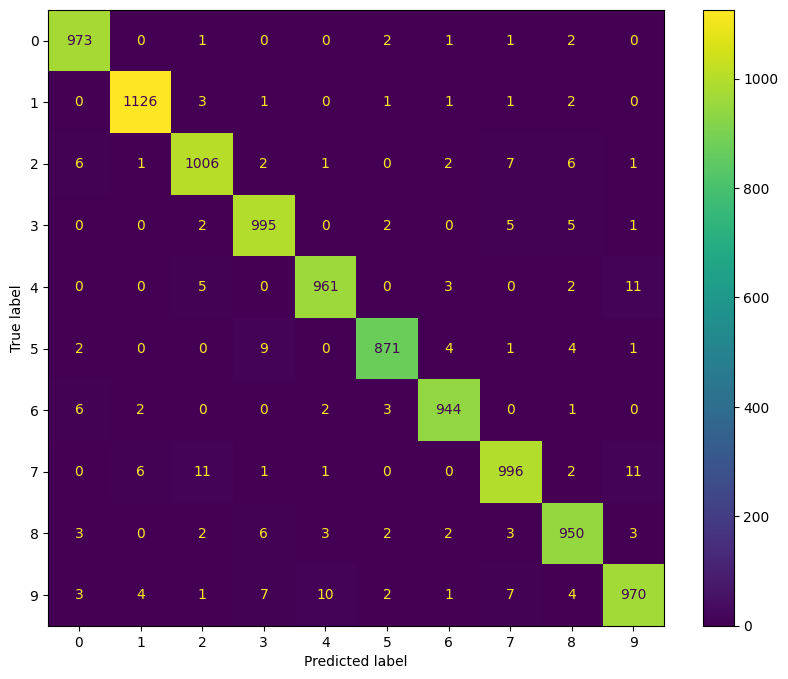

In [11]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"),

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations.
# We encourage more informative and alternate methods to present results.

cm = confusion_matrix(y_eval, y_pred)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
disp.plot()

In [12]:
# Here report the score for the best model
print("Accuracy score: ", round(accuracy_score(y_eval, y_pred),2))
print("Precision score: ", round(precision_score(y_eval, y_pred, average='weighted'),2))
print("Recall score: ", round(recall_score(y_eval, y_pred, average='weighted'),2))
print("F1 score: ", round(f1_score(y_eval, y_pred, average='weighted'),2))
print("Classification report: \n", classification_report(y_eval, y_pred))

Accuracy score:  0.98
Precision score:  0.98
Recall score:  0.98
F1 score:  0.98
Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



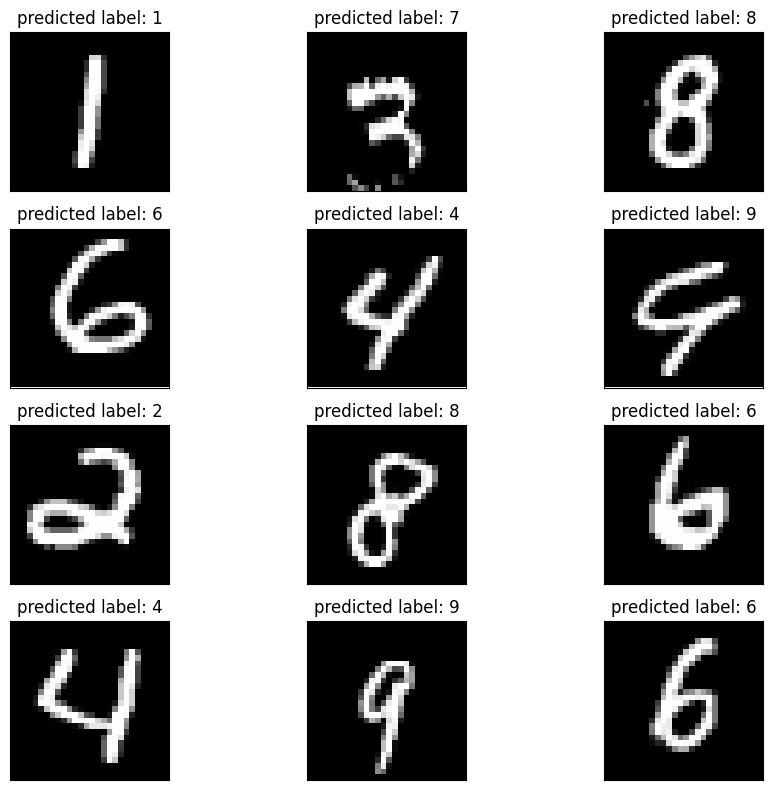

In [13]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
x_eval_unflatten = x_eval.reshape(-1, 28, 28)
vis_predictions(x_eval_unflatten, y_pred, len(x_eval_unflatten))

### 2.1.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

 Model Summary [M1]:
 We used SVM or Support Vector Machine as our first model. This is a straight forward model that is easy to train and interpret. We did not have to go further with hyperparameter tuning, as the default set of values worked well for us. We got a test accuracy of 0.98. We also visualized the predictions on the test set. We can see that the model is able to predict the digits correctly most of the time. However, it does make some mistakes. For example, it predicts 5 instead of 3, 8 instead of 9, 9 instead of 4, etc. Some of the classes have less accuracy than the others.
 As we achieved a good accuracy with SVM without any hyperparameter tuning, we decided to use SVM as our baseline model. We will compare the performance of other models with this model. Currently we have no interesting insights to share. We will do comparison with this baseline model with other models in the next sections and share our insights there.

# 2.2: Model [M2]: *fill-this-in*




### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [14]:
d = None
n = 100
seed = random_seed

test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    train_idxs, val_idxs = ..., ...   # Fill in
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.2.2: Data Preprocessing


In [15]:
# e.g. normalize, flatten input data.

try:
    x_train = x_train.cpu().detach().numpy() # convert to numpy array
    x_eval = x_eval.cpu().detach().numpy() # convert to numpy array
except Exception as e:
    print("x_train and x_eval are already numpy arrays")
    
# flatten the input images
x_train = flatten_input_pixels(x_train)
x_eval = flatten_input_pixels(x_eval)

### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=seed)

### 2.2.4: Fit Model


In [17]:
#  Please save the trained model
filename = 'random_forest_model.sav'
if test_set == 'val':
    # train the model
    model.fit(x_train, y_train)
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))
else:
    print("Loading model from disk...test_set==test")

Loading model from disk...test_set==test


### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [18]:
if test_set == 'test':
    rf = pickle.load(open(filename, 'rb'))
    y_pred = rf.predict(x_eval)
else:
    y_pred = rf.predict(x_eval)

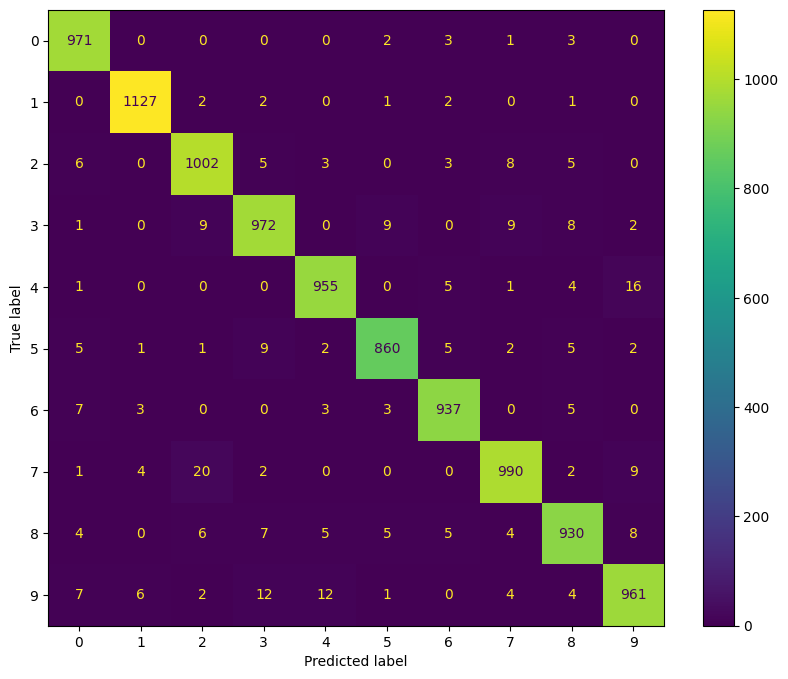

In [19]:
cm = confusion_matrix(y_eval, y_pred)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
disp.plot()

In [20]:
print("Accuracy score: ", round(accuracy_score(y_eval, y_pred),2))
print("Precision score: ", round(precision_score(y_eval, y_pred, average='weighted'),2))
print("Recall score: ", round(recall_score(y_eval, y_pred, average='weighted'),2))
print("F1 score: ", round(f1_score(y_eval, y_pred, average='weighted'),2))
print("Classification report: \n", classification_report(y_eval, y_pred))

Accuracy score:  0.97
Precision score:  0.97
Recall score:  0.97
F1 score:  0.97
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



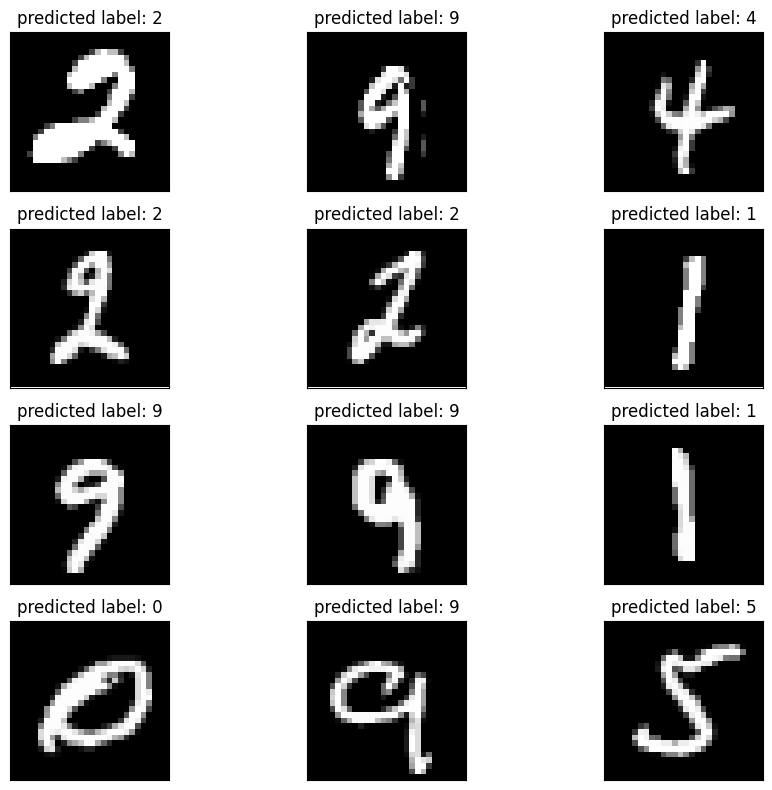

In [21]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
x_eval_unflatten = x_eval.reshape(-1, 28, 28)
vis_predictions(x_eval_unflatten, y_pred, len(x_eval_unflatten))

### 2.2.6: Summary
Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

 
 Model Summary [M2]:
 We used Random Forest Classifier as our first model. This is a straight forward Tree based model that is easy to train and interpret. We did not have to go further with hyperparameter tuning, as the default set of values worked well for us. We got a test accuracy of 0.97. We also visualized the predictions on the test set. We can see that the model is able to predict the digits correctly most of the time. However, it does make some mistakes. For example, it predicts 5 instead of 3, 8 instead of 9, 9 instead of 4, etc. Some of the classes have less accuracy than the others. With no hyperparameter tuning, we got a good accuracy. However, it is performing sligtly worse than SVM. 

# 2.3: Model [M3] (Neural Networks): *fill-this-in*



### 2.3.1: Hyper-parameters

Define hyper-parameters for your method here

In [22]:
# Define your hyperparameters here
learning_rate = 0.001
batch_size_train = 64
batch_size_test = 1000
n_epochs = 10
# other parameters ...




# You don't need the following code, if you can use data from 2.1.1.
# You can also use torch built-in functions (torch.utils.data)

test_set = 'test'  #  or 'test'

# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

# if test_set == 'val':
#     train_idxs, val_idxs = ..., ...   # Fill in
#     x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
#     x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
# else:
#     x_train, y_train = x_trainval, y_trainval
#     x_eval, y_eval = x_test, y_test

### 2.3.2: Data Preprocessing


In [23]:
#
#
# ------- Your Code -------
#
# e.g. normalize, flatten input data.
# Not needed. Done in the transform function earlier.


### 2.3.3: Model

Define your model here

In [24]:
class Net(nn.Module):
   # for MNIST dataset, input is 28x28
    def __init__(self):
         super(Net, self).__init__()
         self.cnn_layers = nn.Sequential(
             # Defining first 2D convolution layer
             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
             nn.BatchNorm2d(32),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             # Defining second 2D convolution layer
             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             
         )
         self.fc1 = nn.Linear(7 * 7 * 64, 10)
         self.softmax = nn.Softmax(dim=1)
         
     
   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### 2.2.4: Fit Model


In [25]:
#
#
# ------- Your Code -------
#
# Example: net = Net(), ....
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [26]:
def train(net, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, n_epochs, patience=5):
    if test_set == 'val':
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_val_accuracy = 0.0
        best_model_state = None
        

        for epoch in range(n_epochs):
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step() 
                running_loss += loss.item()

                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

            train_losses.append(running_loss/len(train_loader))
            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)

            val_loss, val_accuracy = validate(net, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            scheduler.step()

            print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Training Accuracy: {:.2f}%.. ".format(train_accuracies[-1]),
                  "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
                  "Validation Accuracy: {:.2f}%.. ".format(val_accuracies[-1]))

            # Save the best model based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = net.state_dict()
            
            if val_loss < 0.001:
                break
            elif epoch > patience and val_loss > val_losses[-patience]:
                print("Early stopping...")
                print("Best Validation Accuracy: {:.2f}%.. ".format(best_val_accuracy))
                break

            # Plotting for Validation
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 2, 1)
            plt.plot(range(1, epoch+2), train_losses, label='Training Loss')
            plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss Curve')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(range(1, epoch+2), train_accuracies, label='Training Accuracy')
            plt.plot(range(1, epoch+2), val_accuracies, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.title('Accuracy Curve')
            plt.legend()

            plt.tight_layout()
            plt.show()

        return train_losses, val_losses, train_accuracies, val_accuracies, best_model_state

    elif test_set == 'test':
        best_model_state = torch.load('best_model.pth')  # Load the best model

        test_losses = []
        test_accuracies = []

        net.load_state_dict(best_model_state)

        loss, accuracy, y_true, y_pred, x_eval_unflatten = test(net, test_loader)
        test_losses.append(loss)
        test_accuracies.append(accuracy)

        print("Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.2f}%.. ".format(test_accuracies[-1]))


        return test_losses, test_accuracies, y_true, y_pred, x_eval_unflatten


def validate(net, val_loader, criterion):
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    loss = val_loss / len(val_loader)
    accuracy = 100 * val_correct / val_total
    return loss, accuracy


def test(net, test_loader):
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = list()
    y_pred = list()
    x_eval_unflatten = list()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            x_eval_unflatten.extend(inputs.reshape(-1, 28, 28).numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print('Test Loss: {:.3f}'.format(avg_test_loss))
    print('Test Accuracy: {:.2f}%'.format(accuracy))

    return avg_test_loss, accuracy, y_true, y_pred, x_eval_unflatten

In [27]:
# Save your model using torch.save()
if test_set == 'val':
    train_losses, val_losses, train_accuracies, val_accuracies, best_model_state = train(net, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, n_epochs)
    torch.save(best_model_state, 'best_model.pth')



### 2.2.5: Evaluation

Evaluate your model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

In [28]:
#
#
# ------- Your Code -------
# Example:
# net = Net()
# net.load_state_dict(torch.load("PATH"))

if test_set == 'test':
    test_losses, test_accuracies, y_true, y_pred, x_eval_unflatten = train(net, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, n_epochs)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    x_eval_unflatten = np.array(x_eval_unflatten)

Test Loss: 1.472
Test Accuracy: 99.03%
Test Loss: 1.472..  Test Accuracy: 99.03%.. 


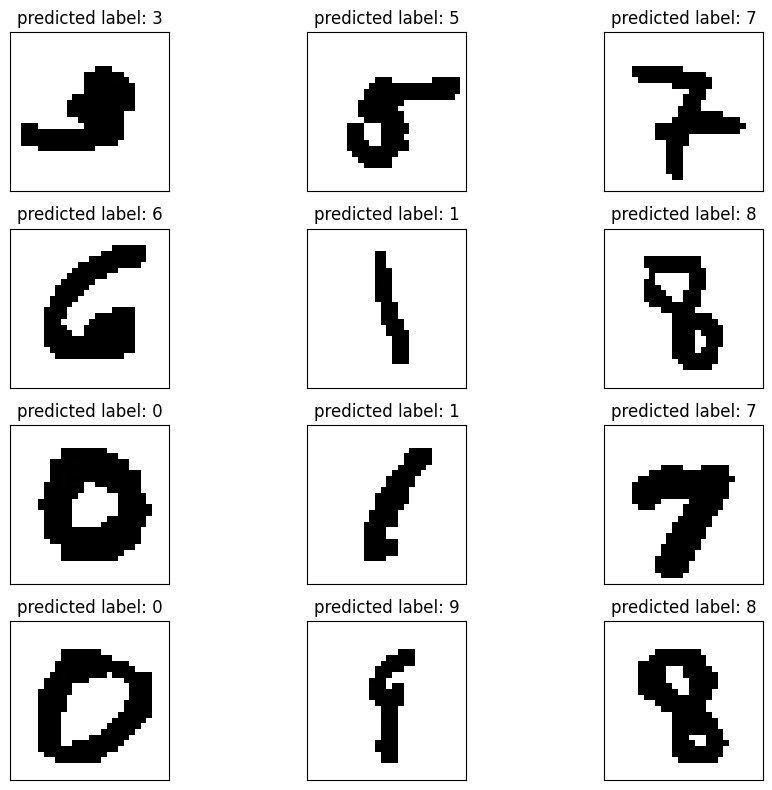

In [29]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)


vis_predictions(x_eval_unflatten, y_pred, len(x_eval_unflatten))

### 2.3.6: Summary
Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...


Model Summary [M3]:
First we tried a simple Feed-forward neural network with 5 hidden layers with ReLU, Dropout and Softmax. However, the accuracy was not good, merely 83% training accuracy. Then we decided to use convolutional neural network or cnn, because cnn has a track record of working great for image data. At first we tried out with one cnn layer with ReLU, BatchNorm, MaxPool and one hidden layer and then a Softmax layer , we got an accuracy of 86% training accuracy which still was not great. Then we tried with using three cnn layers and two hidden layer (with ReLU, BatchNorm, MaxPool and Softmax like before), the result was good this time around 98% training accuracy but the training was taking too much time on our local machine. Then we decided to check if two cnn and one hidden layer (with ReLU, BatchNorm, MaxPool and Softmax like before) would do the job - which turned out to be a great idea. The training took less time and we got around 97.41% of Test accuracy. Till this point we were using SGD optimizer with 0.9 Momentum. 

However, we researched and found out that Adam optimizer usually gives better performance than SGD, so we decided to use Adam with our best two cnn - one hidden network we created earlier. And that drove up our Test accuracy to 99.03%.

We used the following hyperparameters:
* Batch size: 64
* Batch Size for Test set: 1000
* Learning rate: 0.001
* Epochs: 10
* Optimizer: Adam
* Loss function: Cross Entropy Loss
* Two CNN layer - each consisting of 2D Convolution, ReLU, 2D BatchNorm, 2D MaxPool
* One hidden layer - consisting of Linear layer
* Softmax layer

We found out that the following hyperparameters were important:
* Adam optimizer with learning rate 0.001 gave better performance than SGD with learning rate 0.001 and Momentum 0.9.
* Using two CNN layers and one hidden layer gave better performance than using one CNN layer and one hidden layer. However, using three CNN layers and two hidden layers could also work but it was taking too much time to train.
* Using BatchNorm and MaxPool after each 2D Convolution layer gave better performance than using only CNN layers.

# 3. Summary

Enter your final summary here.

You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.

Which model do you recommend to perform digit classification and why?

Feel free to discuss other insightful observations.

In [30]:
result_df = pd.DataFrame(columns=['Model', 'Accuracy'])
result_df.loc[0] = ['SVM', 0.98]
result_df.loc[1] = ['Random Forest', 0.97]
result_df.loc[2] = ['CNN', 0.99]

result_df


,Model,Accuracy
0,SVM,0.98
1,Random Forest,0.97
2,CNN,0.99


Comparison of the three models:
Out of the three models (SVM, Random Forest, CNN), CNN performed the best. It gave us a test accuracy of 99.03%. SVM gave us a test accuracy of 98% and Random Forest gave us a test accuracy of 97%. We recommend using CNN for digit classification because it gave us the best accuracy. However, SVM and Random Forest are also good models. They are easy to train and interpret. They also gave us good accuracy. So, if we want to use a simple model, we can use SVM. SVM also takes less time to train. However, if we want the model with best accuracy, we can use CNN. However, CNN will take longer time to train. 
So, we would recommend using SVM or CNN for digit classification depending on the accuracy and time constraints. If accuracy is more important, go with CNN. If time is more important, go with SVM.